# Exploratory analysis of job offers

In this notebook we are given a **dataset of job offers** with their text description. The goal is to **find similarities between these job offers and/or group them in homogeneous clusters**.

## Data

We are provided a .csv file containing 652 job offers. The fields are the following:
- **id**: An integer value indexing each job offer.
- **Company**: Text indicating the company the job offer belongs to.
- **Title**: Text containing the title of the job offer.
- **Location**: Text displaying the location of the job offer.
- **Responsibilities**: Text describing the responsibilities of the job offer.
- **Minimum Qualifications**: Text specifying the minimum qualifications required for the position.
- **Preferred Qualifications**: Text specifying the preferred qualifications required for the position.

## Strategy

We describe in this section the strategy of the approach we have chosen to solve the exercise. We do so in a high level to give a general idea, please refer to the corresponding section for further details. The strategy consists of several steps:

**1 - Data exploration**
We start by importing the data and get some basic information of some of the fields. For instance, we check for and fill in missing values, and we aggregate along different field subsets in order to check for duplicates.

**2 - Vectorization**
We vectorize the text fields in the dataset. That means that, for every text field, we generate a numerical matrix representing its texts.

**3 - Clustering**
Once we have vectorized the data, we proceed to the clustering of the job offers. We do this separately for each of the text fields we consider, hence obtaining a different grouping of the job offers for each of them.

**4 - Dimensionality reduction and visualization**
In order to visualize the clusterings from the previous step, we perform dimensionality reduction on the resulting data. This allows us to display the job offers on a comprehensible 2-dimension graph, where the separation between clusters becomes meaningful thanks to word clouds indicating the most relevant terms for each of the axes.

**5 - Final combination and conclusions**
We finally combine the clusterings obtained by each of the text fields into a single clustering, which yields for every job offer a label indicating its final cluster. We achieve this by performing a second (meta)clustering and we display the results again in 2 dimensions thanks to another dimensionality reduction.

## 1 - Data exploration

Our goal is to load the data, explore it, correct missing data and check for duplicates. The output of this section is the variable `jobs`.

We start by **importing the packages** and functions we will need throughout the notebook.

In [61]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from wordcloud import WordCloud

We **read the data** and store it in the variable `jobs`.

In [62]:
jobs = pd.read_csv('data/jobs.csv')

We can take a look at the contents of the first rows.

In [63]:
jobs.head()

,id,Company,Title,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,1,Google,"Data Analyst, Product and Tools Operations, Go...","New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
1,2,Google,"Associate Account Strategist (Czech/Slovak), G...","Dublin, Ireland",Communicate with customers via phone and email...,Bachelor's degree or equivalent practical expe...,"Experience in sales, customer service, account..."
2,3,Google,"Solutions Architect, Healthcare and Life Scien...","New York, NY, United States",Help compile customer requirements as well as ...,"BA/BS degree in Computer Science, related Soft...","Master's degree in Computer Science, related E..."
3,4,Google,"Associate Account Strategist (Ukrainian), GMS ...","Dublin, Ireland",Implement creative ways to improve our custome...,Bachelor's degree or equivalent practical expe...,"Experience in leading, motivating and working ..."
4,5,Google,"Solution Architect, Google Cloud Platform (Api...","Amsterdam, Netherlands","Produce required design specifications, provid...",BA/BS degree in a technical or engineering fie...,Experience with or deep understanding of priva...


And also check that we have 652 job offers and the 7 variables specified above.

In [64]:
jobs.shape

(652, 7)

We check for **missing values** and find one entry with missing Responsibilities, Minimum Qualifications and Preferred Qualifications.

In [65]:
jobs[jobs.isnull().any(axis=1)]

,id,Company,Title,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
79,80,Google,"Technical Solutions Consultant, Verily Life Sc...","Mountain View, CA, United States",NaN,NaN,NaN


Since the Title is still available, we decide to keep the entry and replace the missing values with the string 'unavailable'.

In [66]:
jobs = jobs.fillna('unavailable')

We now define a function to compute the **row counts** sharing some values. It groups by the fields passed as parameters, adding the row counts and returns the resulting DataFrame, sorted by the row counts.

In [67]:
def counts(df, fields):
    return df.groupby(fields, as_index=False).size()\
             .rename(columns={'size': 'Count'})\
             .sort_values(by='Count', ascending=False)

We may now use the function `counts` to find out that 638 out of the 652 job offers belong to Google, while the other 14 belong to YouTube.

In [68]:
counts(jobs, 'Company')

,Company,Count
0,Google,638
1,YouTube,14


We see that some Titles in the offers are not unique, mostly for internships.

In [69]:
counts(jobs, 'Title')

,Title,Count
86,Business Intern 2018,35
219,"MBA Intern, Summer 2018",32
68,"BOLD Intern, Summer 2018",21
148,"Field Sales Representative, Google Cloud",9
266,"Partner Sales Engineer, Google Cloud",7
...,...,...
152,"Finance Manager, Google Cloud Customers",1
151,"Finance Director, Google Fixed Assets (GFA)",1
150,"Finance Auditor, Internal Audit",1
146,"Field Marketing Manager, Apigee",1


If we check by Location, we see many job offers from California, however there are jobs in many different countries.

In [70]:
counts(jobs, 'Location')

,Location,Count
65,"Sunnyvale, CA, United States",89
45,"Mountain View, CA, United States",85
18,"Dublin, Ireland",66
59,"San Francisco, CA, United States",34
49,"New York, NY, United States",29
...,...,...
36,"Manila, Philippines",1
48,"Nairobi, Kenya",1
46,"Mumbai, India",1
41,"Minneapolis, MN, United States",1


More surprisingly, many job offers share the same Responsibilities description, again mostly for internships.

In [71]:
counts(jobs, 'Responsibilities')

,Responsibilities,Count
169,Google interns are given a lot of responsibili...,32
341,Responsibilities and detailed projects will be...,32
171,Google interns are given a lot of responsibili...,21
170,Google interns are given a lot of responsibili...,16
157,Engage with prospect organizations to position...,7
...,...,...
155,Engage with Partners and Industry Platforms le...,1
154,"Drive the SP LatAm regional agency strategy, b...",1
153,"Drive strategy, planning, and execution of B2B...",1
152,Drive performance for clients through implemen...,1


The same happens with the Minimum Qualifications.

In [72]:
counts(jobs, 'Minimum Qualifications')

,Minimum Qualifications,Count
403,Currently enrolled in a Bachelor's or Master's...,32
421,Must be pursuing a full-time MBA program with ...,32
396,Be currently enrolled in a 4-year BA/BS progra...,21
353,Bachelor's degree in Computer Science or a rel...,7
105,BA/BS degree in a technical or engineering fie...,6
...,...,...
151,BA/BS degree or equivalent practical experienc...,1
150,BA/BS degree or equivalent practical experienc...,1
149,BA/BS degree or equivalent practical experienc...,1
148,BA/BS degree or equivalent practical experienc...,1


And with the Preferred Qualifications.

In [73]:
counts(jobs, 'Preferred Qualifications')

,Preferred Qualifications,Count
273,Interest in the technology industry and Google...,32
390,"Previous internship experience in Sales, Adver...",32
40,Analytical skills and an interest in taking on...,21
272,Interest in the Internet and Google's technolo...,8
171,"Experience in, and understanding of, data and ...",7
...,...,...
150,"Experience in publisher yield management, ad o...",1
148,Experience in process improvement.\nExperience...,1
147,"Experience in planning, delivering and executi...",1
146,"Experience in planning, delivering and actioni...",1


What actually happens is that several offers are quadruplicated.

In [74]:
counts(jobs, ['Title', 'Location', 'Responsibilities', 'Minimum Qualifications', 'Preferred Qualifications'])[['Title', 'Count']]

,Title,Count
322,"MBA Intern, Summer 2018",4
319,"MBA Intern, Summer 2018",4
140,"Business Intern 2018, Mexico",4
447,"Product Strategist, Growth, YouTube",4
137,"Business Intern 2018, Argentina",4
...,...,...
196,"Digital Analyst, Google Cloud Online Experience",1
195,"Developer Product Marketing Manager, Google Play",1
194,"Demand Generation Marketing Manager, North Ame...",1
193,"Deal Manager, Google Cloud",1


And many others only differ in the Location.

In [75]:
counts(jobs, ['Title', 'Responsibilities', 'Minimum Qualifications', 'Preferred Qualifications'])[['Title', 'Count']]

,Title,Count
234,"MBA Intern, Summer 2018",32
91,Business Intern 2018,32
72,"BOLD Intern, Summer 2018",21
281,"Partner Sales Engineer, Google Cloud",7
163,"Field Sales Representative, Google Cloud (DACH)",6
...,...,...
151,Entity Controller,1
150,Enterprise Customer Development Representative...,1
149,Enterprise Customer Development Representative...,1
148,Enterprise Customer Development Representative...,1


**Conclusion:** After exploring the data, we decide **not to use the field Company** because it contains very little information. We also noticed some duplicates and almost-duplicates, which should belong to the same clusters.

## 2 - Vectorization

We start by defining the 5 text fields we are going to consider. We vectorize them separately to better distinguish their potential individually.

We use a **Tfidf vectorizer** on words (1-grams), using scikit's implementation. This vectorization accounts not only for the frequency of each term but also for the general frequency in all entries, and it normalizes the values so that the l2-norm of each vector is 1.

We store the vectorizers in the dictionary `vectorizers`, indexed by the text fields.

In [76]:
text_fields = ['Title', 'Location', 'Responsibilities', 'Minimum Qualifications', 'Preferred Qualifications']

vectorizers = {field: TfidfVectorizer(stop_words='english') for field in text_fields}

for field in text_fields:
    vectorizers[field].fit(jobs[field])

Once we have the 5 vectorizers fitted to our data, we can **transform the text to numerical matrices**.

These matrices are stored in the dictionary `vectorized_fields`, again indexed by the text fields.

In [77]:
vectorized_fields = {field: pd.DataFrame(vectorizers[field].transform(jobs[field]).toarray(), columns=vectorizers[field].get_feature_names()) for field in text_fields}

vectorized_fields['Title']

,2017,2018,360,abuse,accessories,account,accountant,accounting,acquisitions,activation,...,video,vietnamese,view,visual,vr,waze,web,windows,writer,youtube
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.247223,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.289414,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
650,0.0,0.272495,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Another way of visualizing these matrices is by plotting them. The white vertical stripes correspond to common terms.

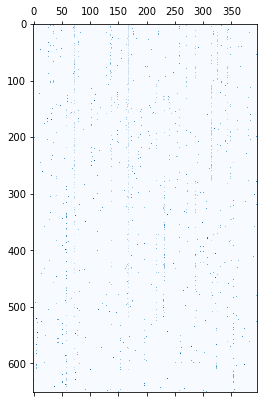

In [78]:
plt.matshow(vectorized_fields['Title'].to_numpy(), cmap='Blues')

**Conclusion**: We have created the dictionaries `vectorizers` and `vectorized_fields`, both indexed by the text fields, which contain the **vectorizers and numerical matrices** for each text field.

## 3 - Clustering

With the numerical matrices, we may now proceed to the **clustering** of the job offers. As mentioned above, we do so separately for each text field, so we get different groupings of job offers.

We will use the **K-means algorithm** to find the clusters, which takes the number of clusters as a parameter. We decide to use a different number of clusters for each text field, depending on the length of their contents.

Hence, we start by fitting a scikit's KMeans object for every text field, and store them in a variable called `kms`.

In [79]:
# Number of clusters
Ks = {
    'Title': 3,
    'Location': 2,
    'Responsibilities': 4,
    'Minimum Qualifications': 4,
    'Preferred Qualifications': 4
}

kms = {field: KMeans(n_clusters=Ks[field], random_state=0) for field in text_fields}

for field in text_fields:
    kms[field].fit(vectorized_fields[field])

After fitting, we may now **append the cluster labels** to our original DataFrame `jobs`. Each job offer has now 5 cluster labels, one for every text field.

In [80]:
for field in text_fields:
    jobs['Cluster ' + field] = kms[field].labels_

jobs[['id', 'Title', 'Cluster Title']]

,id,Title,Cluster Title
0,1,"Data Analyst, Product and Tools Operations, Go...",0
1,2,"Associate Account Strategist (Czech/Slovak), G...",0
2,3,"Solutions Architect, Healthcare and Life Scien...",1
3,4,"Associate Account Strategist (Ukrainian), GMS ...",0
4,5,"Solution Architect, Google Cloud Platform (Api...",1
...,...,...,...
647,648,"Corporate Operations Engineer, Finance IT Support",0
648,649,Associate Legal Counsel (Commercial) Google Cloud,1
649,650,"HR Business Partner, Employee Relations",0
650,651,"User Experience Engineer Intern, Summer 2018",2


We briefly observe the row counts for each of the combinations of these 5 labels. We see some labels agree on large subsets of entries.

In [81]:
cluster_counts = counts(jobs, ['Cluster ' + field for field in text_fields])

cluster_counts

,Cluster Title,Cluster Location,Cluster Responsibilities,Cluster Minimum Qualifications,Cluster Preferred Qualifications,Count
7,0,1,2,0,0,124
2,0,0,2,0,0,114
4,0,0,2,3,0,79
9,1,0,0,0,0,59
10,1,0,0,3,0,54
16,2,0,1,1,3,34
11,1,0,2,0,0,32
20,2,0,3,2,2,32
15,2,0,1,1,1,28
14,1,1,2,0,0,28


As a result of the K-means algorithm, we have the **centroids of each of the clusters**. This is a sort of center of mass of all the entries in that cluster. We can for instance check the **top words** which would correspond to job offers in that position.

We define the function `get_top_terms`, which does exactly that: given a set of points in the space of words and the terms indexing the points, it returns the top n (10 by default) words for each of the points.

In [82]:
def get_top_terms(points, terms, prefix, n=10):
    top_term_indices = points.argsort()[:, ::-1]

    n_points = points.shape[0]

    top_terms = []
    for i in range(n_points):
        top_terms.append([terms[index] for index in top_term_indices[i, :n]])

    top_terms = pd.DataFrame(top_terms).T
    top_terms.columns = [prefix + ' ' + str(i) for i in range(n_points)]

    return top_terms

And so we may use it to print the **top terms for the centroids** of the clusters defined by any of the text fields.

In [83]:
cluster_top_terms = {}
for field in text_fields:
    centroids = kms[field].cluster_centers_
    terms = vectorizers[field].get_feature_names()
    cluster_top_terms[field] = get_top_terms(centroids, terms, 'Cluster')

cluster_top_terms['Title']

,Cluster 0,Cluster 1,Cluster 2
0,manager,cloud,2018
1,marketing,google,intern
2,account,technical,summer
3,sales,sales,business
4,product,manager,mba
5,analyst,services,bold
6,strategy,engineer,mexico
7,lead,platform,colombia
8,business,representative,argentina
9,strategist,field,brazil


For a more visual approach, we can generate **word clouds** containing these terms. The bigger the size of a word, the more common it is.

The function `get_wordclouds` does precisely that.

In [84]:
def get_wordclouds(terms):
    # Create colormap for word clouds
    orig_cmap = plt.cm.gray
    colors = orig_cmap(np.linspace(0.2, 0.6, 50))
    cmap = LinearSegmentedColormap.from_list('mycmap', colors)

    # Iterate over all text fields
    wordclouds = {}
    for field in terms:
        # Iterate over all columns
        field_wordclouds = {}
        for column in terms[field].columns:
            # Restrict top terms
            field_column_terms = terms[field][column]

            # Compute term frequencies based on inverse ranking
            freqs = {}
            for i in range(len(field_column_terms)):
                freqs[field_column_terms[i]] = len(field_column_terms) - i

            # Create and store word cloud
            wc = WordCloud(background_color='white', colormap=cmap)
            field_wordclouds[column] = wc.generate_from_frequencies(freqs)

        # Store field word clouds
        wordclouds[field] = field_wordclouds

    return wordclouds

And the function `display_wordclouds` shows them as an image.

In [85]:
def display_wordclouds(wordclouds, title_prefix):
    for field in wordclouds:
        fig, axs = plt.subplots(1, len(wordclouds[field]), figsize=(6, 3), dpi=150)
        i = 0
        for column in wordclouds[field]:
            wordcloud = wordclouds[field][column]
            axs[i].imshow(wordcloud)
            axs[i].set_title(column)
            axs[i].axis('off')
            i += 1
        plt.suptitle(title_prefix + ' ' + field)

We can now use these functions to easily create and display **word clouds with the top terms per cluster** of each text field.

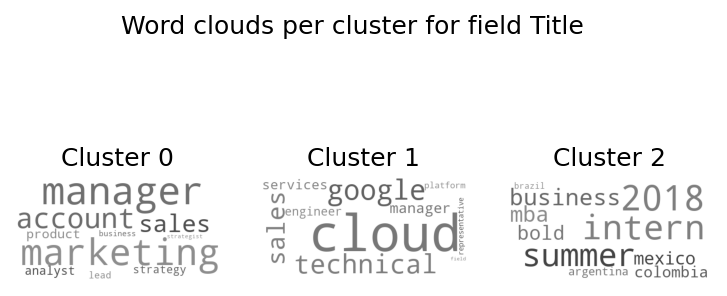

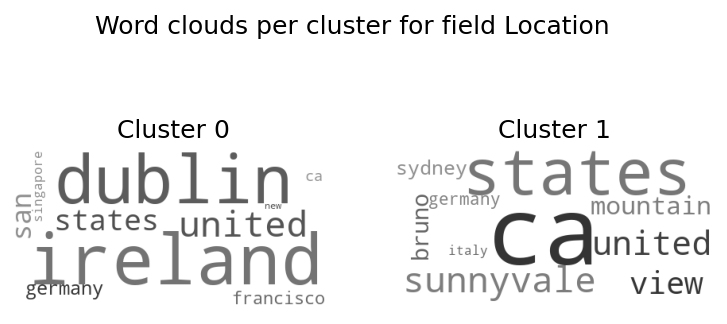

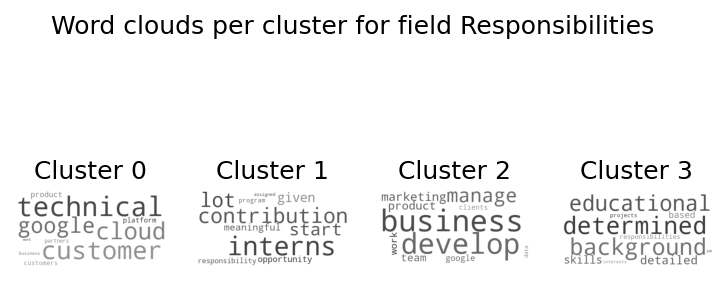

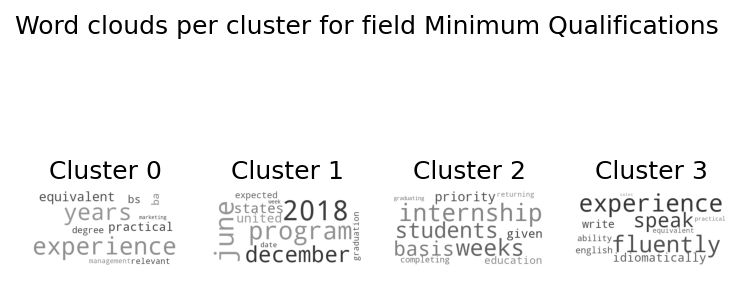

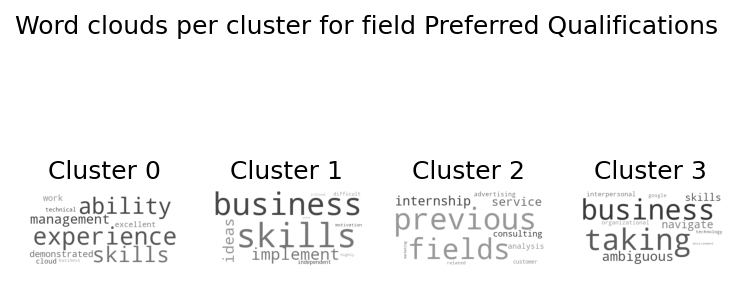

In [86]:
# Generate wordclouds for all clusters for each field
wordclouds = get_wordclouds(cluster_top_terms)
# Display the word clouds
display_wordclouds(wordclouds, 'Word clouds per cluster for field')

**Conclusion**: In this section we have created the columns `Cluster <field>` in the `jobs` DataFrame containing the **cluster labels** for each job offer. In addition, we have also defined the functions `get_top_terms`, `get_wordclouds` and `display_wordclouds`, which we will use later again.

## 4 - Dimensionality reduction and visualization

In this section our goal is to **reduce the dimensionality** of the data in order to **visualize the different clusterings** from the previous section. In particular, we want to project it to a 2-dimensional space and display it with a regular plot.

Since the matrices containing the vectorized text data are sparse, Principal Component Analysis (PCA) would be computationally expensive as it centers the data. Instead, we use **Truncated Singular Value Decomposition (TruncatedSVD)**, which avoids doing so. Indeed, the coefficients of the matrix have the same order of magnitude, so it should not be problematic.

We start by defining a dictionary `svds` containing the scikit's TruncatedSVD objects, indexed by the text fields. Similarly, we define the dictionaries `projections` and `projected_centroids` with the same indexing, containing the 2-dimensional projections of all job offers and centroids, respectively.

In [87]:
n_components = 2

svds = {field: TruncatedSVD(n_components=n_components, random_state=0) for field in text_fields}
projections = {}
projected_centroids = {}

for field in text_fields:
    svds[field] = svds[field].fit(vectorizers[field].transform(jobs[field]))
    projections[field] = svds[field].transform(vectorizers[field].transform(jobs[field]))
    projected_centroids[field] = svds[field].transform(kms[field].cluster_centers_)

For instance, these are the coordinates of all job offers in the 2-dimensional space defined by the TruncatedSVD on the text field `Title`.

In [88]:
projections['Title']

array([[ 0.00885668,  0.24223786],
       [ 0.00496881,  0.1165456 ],
       [ 0.0045658 ,  0.26803805],
       ...,
       [ 0.09504364,  0.06516187],
       [ 0.43764817,  0.06228248],
       [ 0.40437121, -0.00265379]])

We can display the **explained variance** that the projection keeps, for each text field.

This is equivalent to the *amount of information* that we keep after projecting the data to the 2-dimensional space. Here we see that for most variables it is around 10% of the information, which is low but acceptable since we reduce thousands of dimensions to only 2.

In [89]:
for field in text_fields:
    print(field + ':', round(svds[field].explained_variance_ratio_.sum(), 4))

Title: 0.1188
Location: 0.2419
Responsibilities: 0.1154
Minimum Qualifications: 0.1111
Preferred Qualifications: 0.0819


When we reduce dimensionality and project onto a 2-dimensional space, we obtain 2 so-called **components**. These components are linear combinations of the variables in the high-dimensional space.

In our case, each component privileges some words before others. Like before, we can use the function `get_top_terms` to see which ones they are for each of the components.

In [90]:
component_top_terms = {}
for field in text_fields:
    components = svds[field].components_
    terms = vectorizers[field].get_feature_names()
    component_top_terms[field] = get_top_terms(components, terms, 'Component')

component_top_terms['Title']

,Component 0,Component 1
0,2018,google
1,intern,cloud
2,business,manager
3,summer,sales
4,mba,marketing
5,bold,engineer
6,brazil,field
7,colombia,technical
8,mexico,product
9,argentina,platform


And as before we can visualize it as **word clouds** using the functions `get_wordclouds` and `display_wordclouds`.

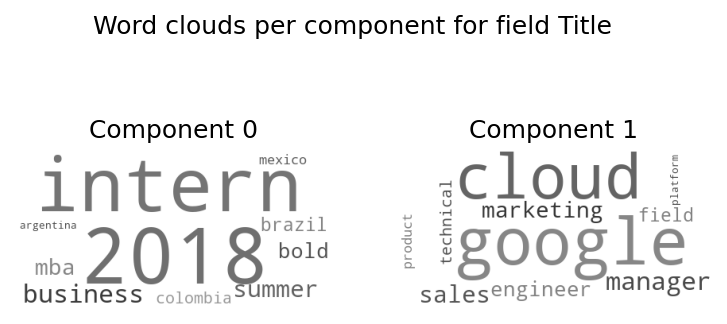

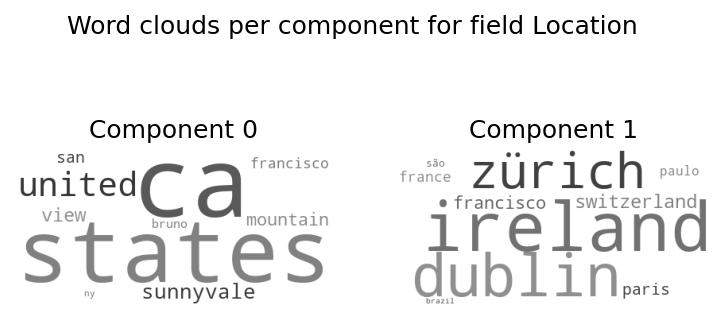

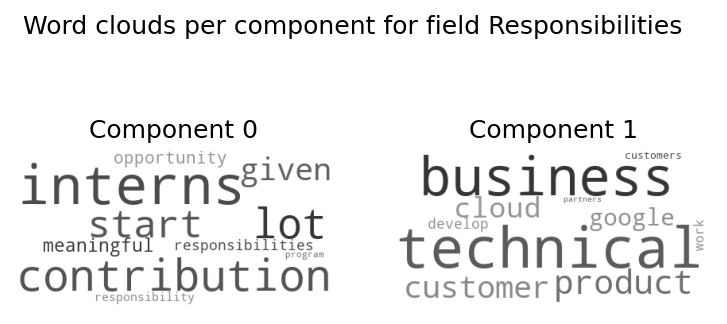

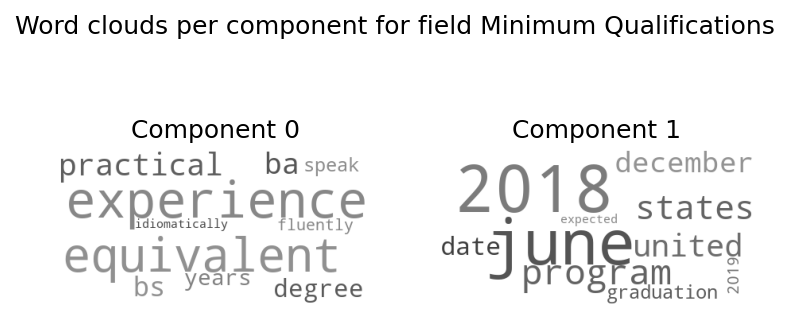

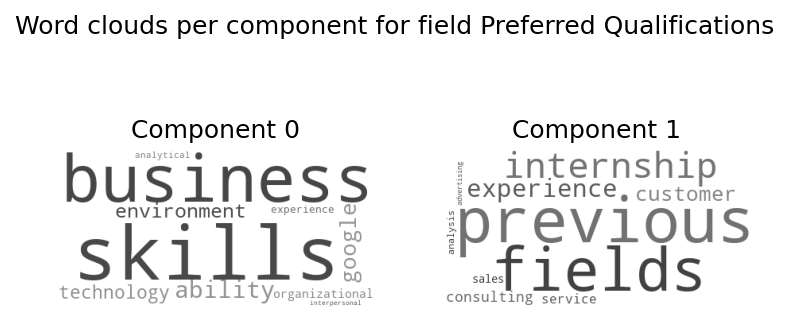

In [91]:
# Generate wordclouds for all components for each field
wordclouds = get_wordclouds(component_top_terms)
# Display the word clouds
display_wordclouds(wordclouds, 'Word clouds per component for field')

But what is most interesting to do now is to **plot the job offers in this 2-dimensional space**, together with these word clouds which give meaning to the components. We do so in the function `plot_components`.

In [92]:
def plot_components(df, projections, centroids, wordclouds, field):
    # Create dataframe with data points (projections)
    data = pd.DataFrame({
        'Component 0': projections[field][:, 0],
        'Component 1': projections[field][:, 1]
    })

    # Add cluster information and group duplicates
    data['Cluster'] = df['Cluster ' + field]
    data = counts(data, ['Component 0', 'Component 1', 'Cluster'])

    # Select field centroids
    centroids = centroids[field]

    # Plot colors
    colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:purple'}

    ## Init plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [4, 1]})

    ## Main plot
    ### Draw points
    axs[0, 1].scatter(x=data['Component 0'], y=data['Component 1'], alpha=0.3, s=20*data['Count'], c=data['Cluster'].apply(lambda i: colors[i]))
    ### Draw cluster centroids
    axs[0, 1].scatter(x=centroids[:, 0], y=centroids[:, 1], marker='s', edgecolor='black', s=100, c=list(colors.values())[:len(centroids)])
    ### Draw title and axis labels
    plt.suptitle('Principal components for field ' + field)
    axs[0, 1].set_xlabel('Component 0')
    axs[0, 1].set_ylabel('Component 1')
    ### Annotate cluster centroids
    hpadding = 0.03
    vpadding = -0.01
    for i in range(len(centroids)):
        axs[0, 1].annotate('Cluster ' + str(i), (centroids[i][0] + hpadding, centroids[i][1] + vpadding), fontsize='large')

    ## Word clouds
    axs[0, 0].imshow(wordclouds[field]['Component 1'])
    axs[0, 0].axis('off')
    axs[1, 1].imshow(wordclouds[field]['Component 0'])
    axs[1, 1].axis('off')
    axs[1, 0].axis('off')

So we can finally **display the distribution of the clusters for each text field on the 2-dimensional space**. We overlay the cluster centers and group offers with the same values into larger points.

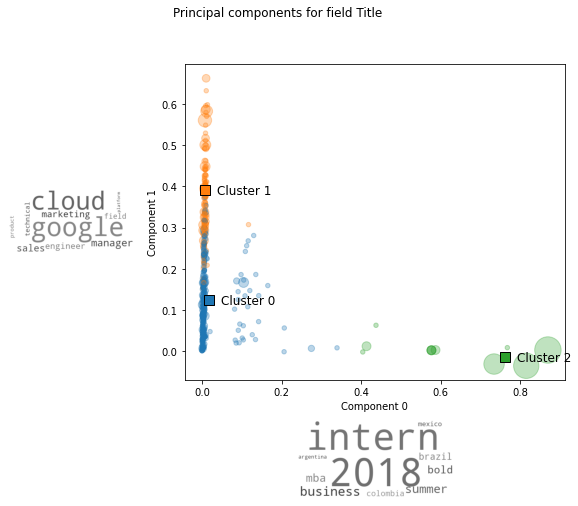

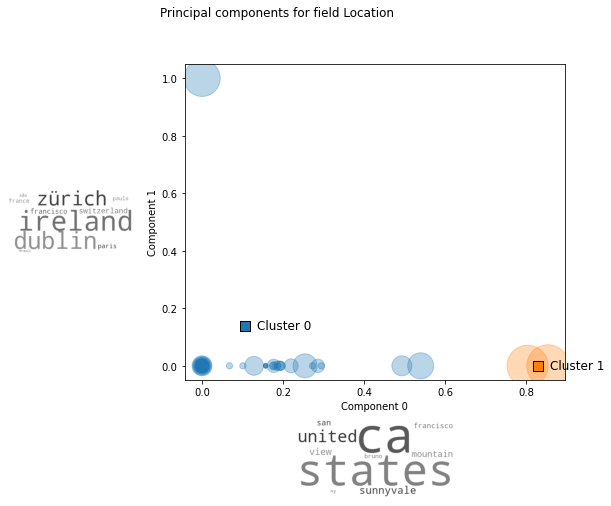

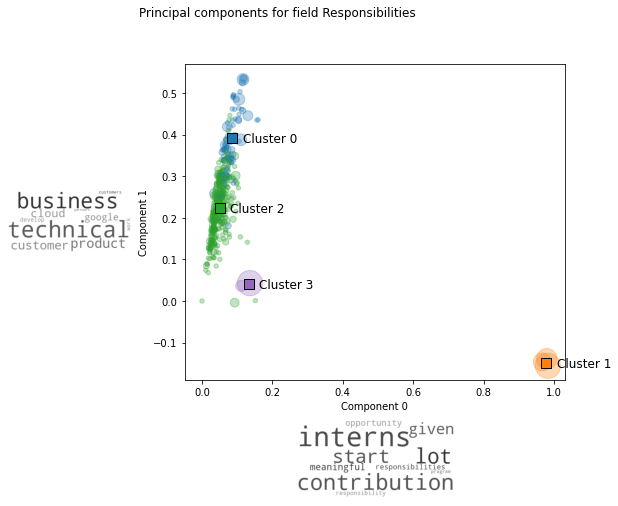

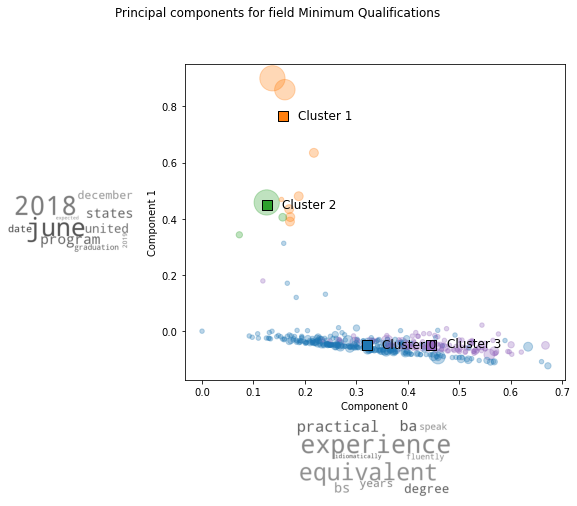

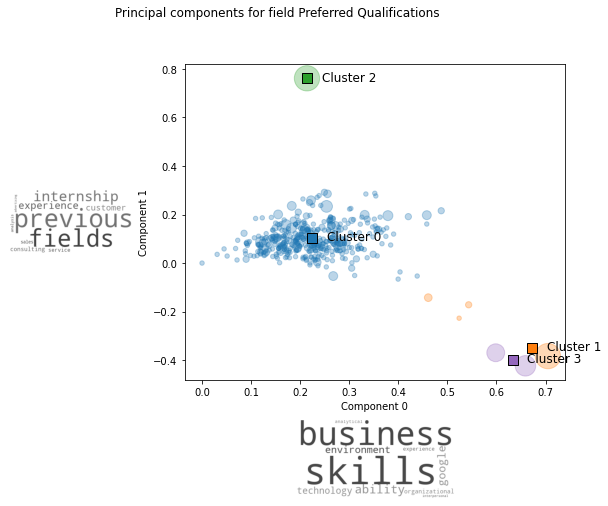

In [93]:
for field in text_fields:
    plot_components(jobs, projections, projected_centroids, wordclouds, field)

**Conclusion**: We have projected the job offers into 5 different 2-dimensional spaces, one for each text field, maximizing the amount of information kept, and we have been able to visualize them in that space.

## 5 - Final classification

So far, as we have mentioned, everything has been done independently on each of the 5 text fields we have considered. We now want to put everything together and **generate one single label by combining the labels for each text field**.

To do so, we want to perform a final (meta)clustering with the 5 cluster label variables. We use once more the **K-means algorithm**.

To avoid establishing an arbitrary order in the clusters, we replace the label columns with their **one-hot encoding**. This increments the space dimension from 5 to 17, but it is still reasonable.

In [94]:
job_clusters = jobs[[field for field in jobs.columns if field.startswith('Cluster')]]
job_clusters = pd.get_dummies(job_clusters, columns=job_clusters.columns, prefix_sep=' ')
job_clusters

,Cluster Title 0,Cluster Title 1,Cluster Title 2,Cluster Location 0,Cluster Location 1,Cluster Responsibilities 0,Cluster Responsibilities 1,Cluster Responsibilities 2,Cluster Responsibilities 3,Cluster Minimum Qualifications 0,Cluster Minimum Qualifications 1,Cluster Minimum Qualifications 2,Cluster Minimum Qualifications 3,Cluster Preferred Qualifications 0,Cluster Preferred Qualifications 1,Cluster Preferred Qualifications 2,Cluster Preferred Qualifications 3
0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
2,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0
3,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
4,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0
648,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
649,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
650,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0


We choose the **number of clusters** and fit the KMeans object with our data.

In [95]:
K = 3

km = KMeans(n_clusters=K, random_state=0)
km.fit(job_clusters)

KMeans(n_clusters=3, random_state=0)

We **append a column with the final labels** to the `jobs` DataFrame, and count how many job offers there are in each cluster.

In [96]:
jobs['Cluster Final'] = km.labels_
counts(jobs, 'Cluster Final')

,Cluster Final,Count
1,1,382
2,2,159
0,0,111


If we want to **visualize the final clustering**, we have to reduce its dimensionality again. In this case, we can perform a **Principal Component Analysis (PCA)**, as the data has only 17 columns, and is not so sparse.

In [97]:
pca = PCA(n_components=2)
pca = pca.fit(job_clusters)
projections = pca.transform(job_clusters)
centroids = pca.transform(km.cluster_centers_)

We can see that now about 58% of the information (**explained variance**) is kept.

In [98]:
pca.explained_variance_ratio_.sum()

0.5780731063179532

We are finally ready to produce the **2-dimensional plot showing all job offers with the final clusters**.

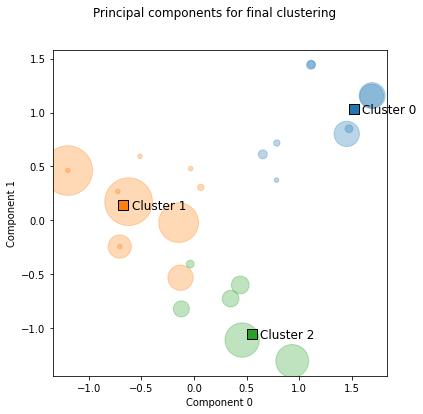

In [99]:
# Create dataframe with data points (projections)
data = pd.DataFrame({
    'Component 0': projections[:, 0],
    'Component 1': projections[:, 1]
})

# Add cluster information and group duplicates
data['Cluster'] = jobs['Cluster Final']
data = counts(data, ['Component 0', 'Component 1', 'Cluster'])

# Plot colors
colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:purple', 4: 'tab:brown', 5: 'tab:pink'}

# Init plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot points
ax.scatter(x=data['Component 0'], y=data['Component 1'], alpha=0.3, s=20*data['Count'], c=data['Cluster'].apply(lambda i: colors[i]))

# Plot centroids
ax.scatter(x=centroids[:, 0], y=centroids[:, 1], marker='s', edgecolor='black', s=100, c=list(colors.values())[:len(centroids)])

# Add titles, axes labels and annotations
plt.suptitle('Principal components for final clustering')
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')

hpadding = 0.08
vpadding = -0.04
for i in range(len(centroids)):
    ax.annotate('Cluster ' + str(i), (centroids[i][0] + hpadding, centroids[i][1] + vpadding), fontsize='large')

The meaning of each cluster becomes clear when we take a look at the job offers in it.

In [100]:
jobs[jobs['Cluster Final'] == 0]

,id,Company,Title,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,Cluster Title,Cluster Location,Cluster Responsibilities,Cluster Minimum Qualifications,Cluster Preferred Qualifications,Cluster Final
130,131,Google,MBA Intern (Korean-English Bilingual) 2018,"Seoul, South Korea",Responsibilities vary by role.,Must be pursuing a full-time MBA program with ...,3 years of relevant work experience in the are...,2,0,2,1,0,0
279,280,Google,"BOLD Intern, Summer 2018","New York, NY, United States",Google interns are given a lot of responsibili...,Be currently enrolled in a 4-year BA/BS progra...,Analytical skills and an interest in taking on...,2,0,1,1,3,0
286,287,Google,Business Intern 2018,"Bucharest, Romania",Responsibilities and detailed projects will be...,Currently enrolled in a Bachelor's or Master's...,"Previous internship experience in Sales, Adver...",2,0,3,2,2,0
288,289,Google,Business Intern 2018,"Wrocław, Poland",Responsibilities and detailed projects will be...,Currently enrolled in a Bachelor's or Master's...,"Previous internship experience in Sales, Adver...",2,0,3,2,2,0
289,290,Google,"MBA Intern, Summer 2018","Sunnyvale, CA, United States",Google interns are given a lot of responsibili...,Must be pursuing a full-time MBA program with ...,Interest in the technology industry and Google...,2,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,639,Google,"Business Intern 2018, Brazil","São Paulo, Brazil",Google interns are given a lot of responsibili...,Be currently enrolled in any major at a univer...,Interest in the Internet and Google's technolo...,2,0,1,1,3,0
639,640,Google,"MBA Intern, Summer 2018","San Bruno, CA, United States",Google interns are given a lot of responsibili...,Must be pursuing a full-time MBA program with ...,Interest in the technology industry and Google...,2,0,1,1,1,0
641,642,Google,"MBA Intern, Summer 2018","San Francisco, CA, United States",Google interns are given a lot of responsibili...,Must be pursuing a full-time MBA program with ...,Interest in the technology industry and Google...,2,0,1,1,1,0
642,643,Google,"Business Intern 2018, Argentina","Buenos Aires, Argentina",Google interns are given a lot of responsibili...,Be currently enrolled in any major at a univer...,Interest in the Internet and Google's technolo...,2,0,1,1,3,0


In [101]:
jobs[jobs['Cluster Final'] == 1]

,id,Company,Title,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,Cluster Title,Cluster Location,Cluster Responsibilities,Cluster Minimum Qualifications,Cluster Preferred Qualifications,Cluster Final
0,1,Google,"Data Analyst, Product and Tools Operations, Go...","New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...,0,0,2,0,0,1
11,12,Google,"Chief of Staff, Google Hardware","Mountain View, CA, United States",Develop a key performance indicators (KPI) das...,BA/BS degree or equivalent practical experienc...,MBA and/or graduate degree.\nExperience partne...,0,1,2,0,0,1
14,15,Google,Technical Contracts Manager,"Mountain View, CA, United States",Coordinate and facilitate between internal tea...,"BA/BS degree in Business, Computer Science or ...","MBA, MS, JD or other advanced degree.\n2 years...",0,1,2,0,0,1
16,17,Google,"Vendor Operations Specialist (EMEA), Google Te...","Dublin, Ireland",Support the management of outsourced operation...,Bachelor's degree or equivalent practical expe...,Project management experience.\nResource Plann...,1,0,2,0,0,1
19,20,Google,Measurement and Attribution Specialist (Northe...,"Dublin, Ireland",Work intensively on a project basis with our c...,BA/BS degree or equivalent practical experienc...,Relevant experience in creating online marketi...,0,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,648,Google,"Corporate Operations Engineer, Finance IT Support","Sunnyvale, CA, United States",Serve as subject matter expert resource on bes...,BS degree or equivalent practical experience.\...,Experience with software development processes...,0,1,2,0,0,1
648,649,Google,Associate Legal Counsel (Commercial) Google Cloud,"London, United Kingdom",Negotiate a range of commercial agreements wit...,BA/BS/LLB degree or equivalent practical exper...,Extensive experience of advising on data prote...,1,0,2,0,0,1
649,650,Google,"HR Business Partner, Employee Relations","Dublin, Ireland",Partner with the other Global Investigations t...,BA/BS degree or equivalent practical experienc...,CIPD qualification or equivalent.\nExperience ...,0,0,2,0,0,1
650,651,Google,"User Experience Engineer Intern, Summer 2018","San Bruno, CA, United States",Specific responsibilities vary by project area.,Currently pursuing a Bachelor’s degree in Comp...,Currently pursuing a MS or PhD in Computer Sci...,2,0,2,0,0,1


In [102]:
jobs[jobs['Cluster Final'] == 2]

,id,Company,Title,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,Cluster Title,Cluster Location,Cluster Responsibilities,Cluster Minimum Qualifications,Cluster Preferred Qualifications,Cluster Final
1,2,Google,"Associate Account Strategist (Czech/Slovak), G...","Dublin, Ireland",Communicate with customers via phone and email...,Bachelor's degree or equivalent practical expe...,"Experience in sales, customer service, account...",0,0,0,3,0,2
2,3,Google,"Solutions Architect, Healthcare and Life Scien...","New York, NY, United States",Help compile customer requirements as well as ...,"BA/BS degree in Computer Science, related Soft...","Master's degree in Computer Science, related E...",1,0,0,0,0,2
3,4,Google,"Associate Account Strategist (Ukrainian), GMS ...","Dublin, Ireland",Implement creative ways to improve our custome...,Bachelor's degree or equivalent practical expe...,"Experience in leading, motivating and working ...",0,0,0,3,0,2
4,5,Google,"Solution Architect, Google Cloud Platform (Api...","Amsterdam, Netherlands","Produce required design specifications, provid...",BA/BS degree in a technical or engineering fie...,Experience with or deep understanding of priva...,1,0,0,3,0,2
5,6,Google,"Machine Learning Product Specialist, Google Cl...","Frankfurt, Germany",Work as part of the Sales team to identify and...,BA/BS degree in Computer Science or a related ...,Master's degree in Computer Science or a relat...,1,0,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,477,Google,"SMB Sales Manager, International, Google Cloud","Dublin, Ireland",Lead a team of managers and their teams to ach...,BA/BS degree or equivalent practical experienc...,MBA.\nExperience managing senior stakeholders ...,1,0,2,3,0,2
497,498,Google,Enterprise Customer Development Representative...,"Dublin, Ireland",Contribute to account/territory strategy by pe...,BA/BS degree or equivalent practical experienc...,"Experience or internship in sales, customer su...",1,0,0,3,0,2
502,503,Google,"Go-to-Market Specialist, Google Cloud","Sunnyvale, CA, United States","Build and tell the Google Cloud story, display...",BA/BS degree in a Technical or Engineering fie...,"MBA, Master's degree or PhD in a Management, T...",1,1,0,0,0,2
518,519,Google,"Go-to-Market Specialist, Google Cloud","Kirkland, WA, United States","Build and tell the Google Cloud story, display...",BA/BS degree in a Technical or Engineering fie...,"MBA, Master's degree or PhD in a Management, T...",1,0,0,0,0,2


**Conclusion**: We have obtained a **final classification of all job offers into 3 clusters**, together with a 2-dimensional plot that allows us to visualize the cluster separation. We could check the partial clusters (per text field) to infer the high-level description of the job offers in every final cluster, however in this case we can simply take a look at them. We find the following:
- Cluster 0 contains **internship positions** in several programs, some of which are duplicated or differ only in the Location.
- Cluster 1 contains **high-rank positions**, such as **managers**, and in general positions not suitable for the other clusters.
- Cluster 2 contains mostly **engineering-oriented positions**, often related to **Machine Learning** or **Google Cloud**.

Some further conclusions can be drawn by incrementing the number of final clusters. For instance, we can split cluster 0 into two subclusters, as there are two main internship programs. Similarly, cluster 1 may be split into three subclusters: two for the manager-like positions, depending on the Location (California vs. rest of the world), and one for more technical positions.